In [1]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from typing import Tuple


In [2]:
def get_classification_model() -> Tuple[RandomForestClassifier, StandardScaler, LabelEncoder]:
    # Load dataset from the Excel file
    file_path = './content/cancer patient data sets.xlsx'
    df = pd.read_excel(file_path)

    label_encoder = LabelEncoder()
    df['Gender'] = label_encoder.fit_transform(df['Gender'])
    df['Level'] = label_encoder.fit_transform(df['Level'])

    X = df.drop(columns=['Patient Id', 'Level'])  # Drop non-predictive columns
    y = df['Level']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Model Accuracy: {accuracy * 100:.2f}%")

    return model, scaler, label_encoder


In [3]:
def cancer_questionaire_tool():
    """
    A Function to evaluate chance of cancer. Use the tool when someone asks to evaluate their chances of being infected by cancer.
    Output: The level of Chance Low, Medium, High
    """
    questions = [
    "What is your age?",
    "What is your gender? (1: Female, 2: Male)",
    "Rate the air pollution in your area (1 to 10):",
    "Rate your alcohol consumption (1 to 10):",
    "Rate the severity of your dust allergy (1 to 10):",
    "Rate your exposure to occupational hazards (1 to 10):",
    "Rate your genetic risk of cancer (1 to 10):",
    "Rate the severity of your chronic lung disease (1 to 10):",
    "Rate how balanced your diet is (1 to 10):",
    "Rate your obesity level (1 to 10):",
    "Rate the level of smoking (1 to 10):",
    "Rate the passive smoker risk (1 to 10):",
    "Rate your chest pain severity (1 to 10):",
    "Rate your coughing blood level (1 to 10):",
    "Rate your fatigue level (1 to 10):",
    "Rate your weight loss severity (1 to 10):",
    "Rate your shortness of breath severity (1 to 10):",
    "Rate your wheezing level (1 to 10):",
    "Rate the swallowing difficulty (1 to 10):",
    "Rate the clubbing of your finger nails (1 to 10):",
    "Rate the frequency of colds (1 to 10):",
    "Rate your dry cough level (1 to 10):",
    "Rate your snoring severity (1 to 10):"
    ]
    model, scaler, encoder = get_classification_model()
    print("\nPlease answer the following questions:")
    user_input = []
    for question in questions:
        answer = float(input(question))
        user_input.append(answer)

    # Preprocess user input
    user_input_scaled = scaler.transform([user_input])  # Match user input to dataset features

    # Make a prediction
    prediction = model.predict(user_input_scaled)
    predicted_level = encoder.inverse_transform(prediction)

    print(f"\nPredicted Cancer Risk Level: {predicted_level[0]}")
    
    return predicted_level[0]

In [11]:
#Test cell

cancer_questionaire_tool()

Model Accuracy: 100.00%

Please answer the following questions:


ValueError: could not convert string to float: ''

In [74]:
def appointment_registration(time: str, date:str):
    """
        A tool call for appointment registration on hospital departments
        accepts two parameters

        time: Time of appointment
        date: Date of appointment

        return 'Success' or 'Slot Unavailable' for appointment possible or slot unavailable
    """
    # mysql connect
    # try booking
    # if fails return "Slot Available"
    # if sucess return "Success"
    return "Slot Unavailable"

In [75]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import display, Image
from langchain_openai import ChatOpenAI

In [76]:
class State(MessagesState):
    pass

llm = ChatOpenAI(temperature=0, model="llama3.2-optimized", base_url="http://localhost:11434/v1", api_key="llama3.2")
tools = [cancer_questionaire_tool, appointment_registration]
tooler = llm.bind_tools(tools)
tooler

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x0000021577FBDCC0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x0000021577FBC100>, root_client=<openai.OpenAI object at 0x0000021578012E60>, root_async_client=<openai.AsyncOpenAI object at 0x0000021577FBDCF0>, model_name='llama3.2-optimized', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'), openai_api_base='http://localhost:11434/v1'), kwargs={'tools': [{'type': 'function', 'function': {'name': 'cancer_questionaire_tool', 'description': 'A Function to evaluate chance of cancer. Use the tool when someone asks to evaluate their chances of being infected by cancer.\nOutput: The level of Chance Low, Medium, High', 'parameters': {'properties': {}, 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'appointment_registration', 'description': 'A tool call for appointment registration on hospital departments\naccepts two paramete

In [77]:
def tool_llm_node(state:State):
    return {"messages": tooler.invoke(state["messages"])}

In [78]:
graph = StateGraph(State)
graph.add_node("assistant", tool_llm_node)
graph.add_node("tools", ToolNode(tools))

graph.add_edge(START, "assistant")
graph.add_conditional_edges("assistant", tools_condition)
graph.add_edge("tools", "assistant")

react = graph.compile()


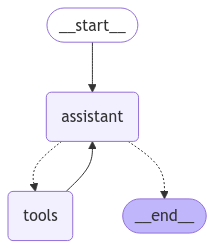

In [66]:
display(Image(react.get_graph(xray=True).draw_mermaid_png()))


In [79]:
inp = input("Prompt : ")
messages = react.invoke({"messages": [HumanMessage(content=inp)]})

print(messages)
for m in messages['messages']:
    m.pretty_print()




{'messages': [HumanMessage(content='Please book an appointment on 04/02/2025 on 4:00 PM', additional_kwargs={}, response_metadata={}, id='966b7b84-243b-4a30-8048-a5e02137641f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5eoetftc', 'function': {'arguments': '{"date":"04/02/2025","time":"4:00 PM"}', 'name': 'appointment_registration'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 305, 'total_tokens': 336, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'llama3.2-optimized', 'system_fingerprint': 'fp_ollama', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-601aea0e-8654-456f-9b14-c7d783daec9c-0', tool_calls=[{'name': 'appointment_registration', 'args': {'date': '04/02/2025', 'time': '4:00 PM'}, 'id': 'call_5eoetftc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 305, 'output_tokens': 31, 'total_tokens': 336, 'input_token_details